# CSC 8830 — Module 2 Assignment (Notebook)

This notebook follows the assignment steps:



## 0) Setup
Install deps (run once in your environment):

```bash
pip install opencv-python numpy matplotlib pandas
```

**Folder convention** (edit if you want):
- Calibration images: `data/calib_images/`
- Measurement image: `data/measure_images/object.jpg`
- Outputs: `outputs/`


In [1]:
pip install opencv-python numpy matplotlib pandas


In [2]:
import os
import glob
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

os.makedirs('outputs', exist_ok=True)
os.makedirs('data/calib_images', exist_ok=True)
os.makedirs('data/measure_images', exist_ok=True)

print('OpenCV:', cv2.__version__)


OpenCV: 4.13.0


## 1) Step 1 — Camera calibration (OpenCV)

**What you need**
- A printed chessboard
- **Inner corners** count (e.g., 9×6)
- **Square size** in **mm** (measure it with a ruler)
- 15–25 sharp images from different angles and distances

Put images in: `data/calib_images/`.


In [4]:
# ---- USER SETTINGS (edit these) ----
PATTERN_COLS = 10   # number of inner corners across
PATTERN_ROWS = 7   # number of inner corners down
SQUARE_SIZE_MM = 22.5

CALIB_GLOB = 'data/calib_images/*'
CALIB_OUT_NPZ = 'outputs/camera_params.npz'
CALIB_REPORT_JSON = 'outputs/calib_report.json'

images = sorted([p for p in glob.glob(CALIB_GLOB) if os.path.isfile(p)])
print('Found calibration images:', len(images))
images[:5]


Found calibration images: 21


['data/calib_images/WhatsApp Image 2026-02-02 at 11.38.12 PM.jpeg',
 'data/calib_images/WhatsApp Image 2026-02-02 at 11.38.13 PM (1).jpeg',
 'data/calib_images/WhatsApp Image 2026-02-02 at 11.38.13 PM (2).jpeg',
 'data/calib_images/WhatsApp Image 2026-02-02 at 11.38.13 PM.jpeg',
 'data/calib_images/WhatsApp Image 2026-02-02 at 11.38.14 PM.jpeg']

Usable chessboard detections: 17


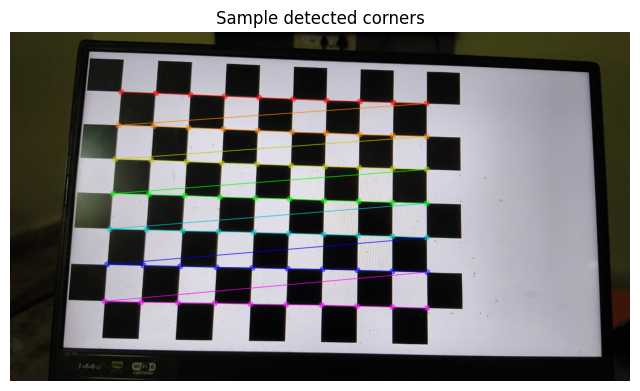

In [5]:
pattern_size = (PATTERN_COLS, PATTERN_ROWS)

# Prepare object points in chessboard coordinate frame
# e.g. (0,0,0), (1,0,0), ..., scaled by square size
objp = np.zeros((PATTERN_ROWS * PATTERN_COLS, 3), np.float32)
objp[:, :2] = np.mgrid[0:PATTERN_COLS, 0:PATTERN_ROWS].T.reshape(-1, 2)
objp *= (SQUARE_SIZE_MM / 1000.0)  # convert mm -> meters

objpoints = []  # 3d points in real world space
imgpoints = []  # 2d points in image plane

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)

good = 0
sample_vis = None
img_shape = None

for path in images:
    img = cv2.imread(path)
    if img is None:
        continue
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_shape = gray.shape[::-1]

    ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)
    if ret:
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        objpoints.append(objp)
        imgpoints.append(corners2)
        good += 1

        if sample_vis is None:
            vis = img.copy()
            cv2.drawChessboardCorners(vis, pattern_size, corners2, ret)
            sample_vis = vis

print('Usable chessboard detections:', good)
if sample_vis is not None:
    plt.figure(figsize=(8,5))
    plt.imshow(cv2.cvtColor(sample_vis, cv2.COLOR_BGR2RGB))
    plt.title('Sample detected corners')
    plt.axis('off')
    plt.show()


In [6]:
assert good >= 8, 'Not enough valid chessboard detections. Add more images / improve lighting / ensure correct inner-corner counts.'

# Calibrate
ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)

# Reprojection error
total_error = 0.0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], K, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
    total_error += error
mean_error = total_error / len(objpoints)

print('RMS:', ret)
print('Mean reprojection error (px):', mean_error)
print('K (intrinsics):\n', K)
print('dist:', dist.ravel())

np.savez(CALIB_OUT_NPZ, K=K, dist=dist, img_shape=img_shape, rms=ret, mean_reproj_px=mean_error)

report = {
    'pattern_cols': PATTERN_COLS,
    'pattern_rows': PATTERN_ROWS,
    'square_size_mm': SQUARE_SIZE_MM,
    'num_images_total': len(images),
    'num_images_used': int(good),
    'rms': float(ret),
    'mean_reproj_px': float(mean_error),
    'K': K.tolist(),
    'dist': dist.ravel().tolist(),
    'img_shape_w_h': [int(img_shape[0]), int(img_shape[1])]
}
with open(CALIB_REPORT_JSON, 'w') as f:
    json.dump(report, f, indent=2)

print('Saved:', CALIB_OUT_NPZ)
print('Saved:', CALIB_REPORT_JSON)


RMS: 0.5051929959950864
Mean reprojection error (px): 0.04134231551092069
K (intrinsics):
 [[1.05034542e+03 0.00000000e+00 6.40714900e+02]
 [0.00000000e+00 1.05101881e+03 3.57294901e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist: [ 1.98107075e-01 -8.51786657e-01  2.91426827e-04  1.30925140e-03
  9.75212419e-01]
Saved: outputs/camera_params.npz
Saved: outputs/calib_report.json


Saved: outputs/undistorted_sample.jpg


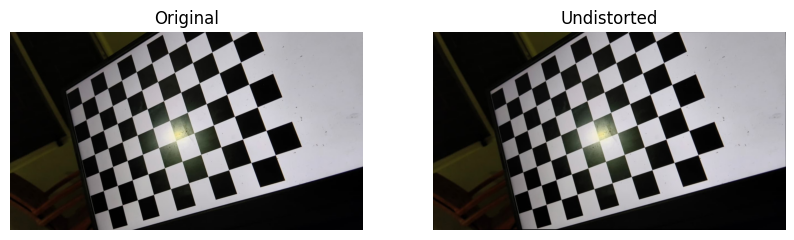

In [7]:
# Undistort a sample image for your report
sample_path = images[0]
img = cv2.imread(sample_path)
h, w = img.shape[:2]
newK, roi = cv2.getOptimalNewCameraMatrix(K, dist, (w,h), 1, (w,h))
und = cv2.undistort(img, K, dist, None, newK)
out_path = 'outputs/undistorted_sample.jpg'
cv2.imwrite(out_path, und)
print('Saved:', out_path)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(und, cv2.COLOR_BGR2RGB))
plt.title('Undistorted')
plt.axis('off')
plt.show()


## 2) Step 2 — Measure real-world 2D dimensions using perspective projection equations

We use the pinhole model (intrinsics from calibration):

\[ u = f_x \frac{X}{Z} + c_x, \quad v = f_y \frac{Y}{Z} + c_y \]

Assuming the object face is approximately **fronto-parallel** (flat and facing the camera) and at known distance **Z**:

\[ X = (u-c_x)\frac{Z}{f_x}, \quad Y = (v-c_y)\frac{Z}{f_y} \]

Then compute the real distance between two points in the (X,Y) plane.

**Important:** In Step 3, the distance must be **greater than 2 meters**.


In [8]:
# Load calibration params
params = np.load(CALIB_OUT_NPZ)
K = params['K']
dist = params['dist']

fx, fy = float(K[0,0]), float(K[1,1])
cx, cy = float(K[0,2]), float(K[1,2])
print('fx, fy, cx, cy:', fx, fy, cx, cy)


fx, fy, cx, cy: 1050.3454249012964 1051.0188113912802 640.7149000650131 357.29490103502263


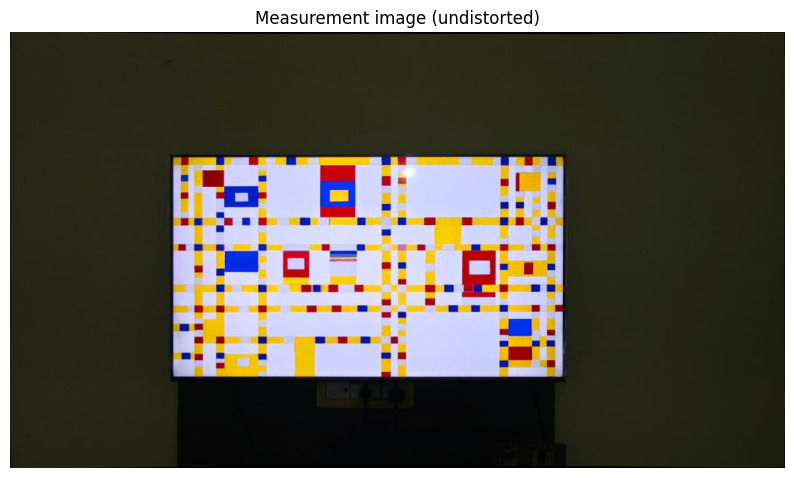

In [18]:
# ---- USER SETTINGS (edit these) ----
MEASURE_IMAGE = '/content/data/measure_images/WhatsApp Image 2026-02-02 at 11.08.21 PM.jpeg'
Z_METERS = 2.00  # distance camera->object (must be > 2m for Step 3 validation)

img = cv2.imread(MEASURE_IMAGE)
assert img is not None, f'Could not read {MEASURE_IMAGE}. Put your measurement image there or change MEASURE_IMAGE.'

# Undistort for better accuracy
h, w = img.shape[:2]
newK, roi = cv2.getOptimalNewCameraMatrix(K, dist, (w,h), 1, (w,h))
und = cv2.undistort(img, K, dist, None, newK)

plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(und, cv2.COLOR_BGR2RGB))
plt.title('Measurement image (undistorted)')
plt.axis('off')
plt.show()


### Pick points
Option A (recommended): **OpenCV click window** (works best in a normal local Python environment).

Option B: If OpenCV window clicking is flaky in your notebook, use the **manual pixel coordinate** input cell below.


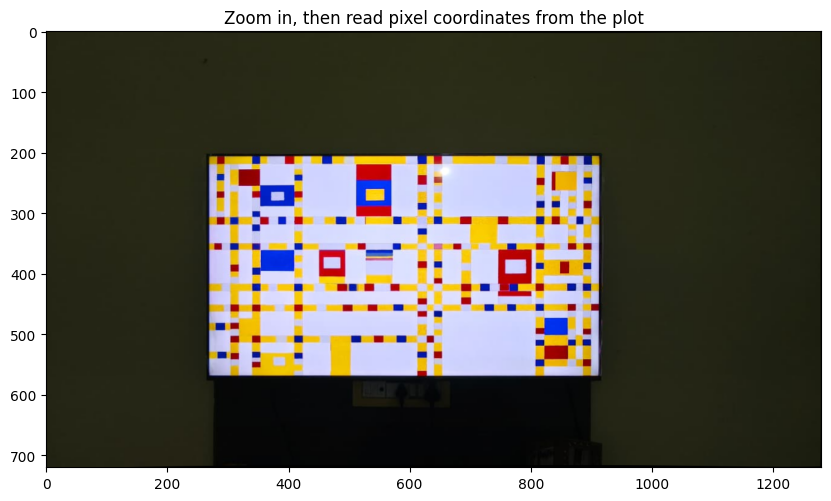

In [13]:
plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(und, cv2.COLOR_BGR2RGB))
plt.title("Zoom in, then read pixel coordinates from the plot")
plt.axis("on")
plt.show()


In [20]:
# Option B: manual pixel coordinates (uncomment and fill)
# clicked = [(u1,v1), (u2,v2), (u3,v3), (u4,v4)]
clicked = [(266, 387), (912, 387), (589, 206), (589, 568)]
pass


In [21]:
assert len(clicked) >= 4, 'Need 4 points. Re-run the clicking cell.'

(u1,v1), (u2,v2), (u3,v3), (u4,v4) = clicked[:4]

def pixel_to_metric(u, v, Z, fx, fy, cx, cy):
    # X,Y in meters assuming constant depth Z
    X = (u - cx) * (Z / fx)
    Y = (v - cy) * (Z / fy)
    return X, Y

X1, Y1 = pixel_to_metric(u1, v1, Z_METERS, fx, fy, cx, cy)
X2, Y2 = pixel_to_metric(u2, v2, Z_METERS, fx, fy, cx, cy)
X3, Y3 = pixel_to_metric(u3, v3, Z_METERS, fx, fy, cx, cy)
X4, Y4 = pixel_to_metric(u4, v4, Z_METERS, fx, fy, cx, cy)

width_m = float(np.hypot(X2 - X1, Y2 - Y1))
height_m = float(np.hypot(X4 - X3, Y4 - Y3))

print('Estimated width (m): ', width_m)
print('Estimated height (m):', height_m)
print('Estimated width (cm): ', width_m * 100)
print('Estimated height (cm):', height_m * 100)

with open('outputs/measurement_result.json', 'w') as f:
    json.dump({
        'image': MEASURE_IMAGE,
        'Z_m': float(Z_METERS),
        'pixels': {'p1': [int(u1),int(v1)], 'p2': [int(u2),int(v2)], 'p3': [int(u3),int(v3)], 'p4': [int(u4),int(v4)]},
        'width_m': width_m,
        'height_m': height_m,
    }, f, indent=2)
print('Saved: outputs/measurement_result.json')


Estimated width (m):  1.2300715263470705
Estimated height (m): 0.6888554154816783
Estimated width (cm):  123.00715263470705
Estimated height (cm): 68.88554154816782
Saved: outputs/measurement_result.json


## 3) Step 3 — Validation experiment (> 2 meters)

Measure the **true** object width/height with a ruler/tape, then compute errors.


In [22]:
# ---- USER SETTINGS (fill ground truth) ----
GT_WIDTH_M = 1.2176

GT_HEIGHT_M = 0.6849

assert GT_WIDTH_M is not None and GT_HEIGHT_M is not None, 'Fill GT_WIDTH_M and GT_HEIGHT_M with your measured ground-truth values.'

abs_err_w_cm = abs(width_m - GT_WIDTH_M) * 100
abs_err_h_cm = abs(height_m - GT_HEIGHT_M) * 100
pct_err_w = abs(width_m - GT_WIDTH_M) / GT_WIDTH_M * 100
pct_err_h = abs(height_m - GT_HEIGHT_M) / GT_HEIGHT_M * 100

df = pd.DataFrame([
    {'dimension': 'width',  'gt_m': GT_WIDTH_M,  'est_m': width_m,  'abs_err_cm': abs_err_w_cm, 'pct_err_%': pct_err_w},
    {'dimension': 'height', 'gt_m': GT_HEIGHT_M, 'est_m': height_m, 'abs_err_cm': abs_err_h_cm, 'pct_err_%': pct_err_h},
])
df


,dimension,gt_m,est_m,abs_err_cm,pct_err_%
0,width,1.2176,1.230072,1.247153,1.024271
1,height,0.6849,0.688855,0.395542,0.577517


In [17]:
df.to_csv('outputs/validation_table.csv', index=False)
print('Saved: outputs/validation_table.csv')


Saved: outputs/validation_table.csv
